In [1]:
import pandas as pd
import numpy as np

In [2]:
origin_data = pd.read_csv('california_3938_2016_minute_data_modify_carbon.csv')
origin_data.head()

,Year,Month,Day,Hour,Minute,Downwelling Global Solar [W/m2],Outdoor Drybulb Temperature [C],Wind Speed [m/s],Wind Direction [deg from N],Day Type,Equipment Electric Power [kW],Electricity Pricing [$/kWh],Occupancy,Carbon Intensity [kg/kWh]
0,2016,6,1,0,0,-1.2,12.0,2.2,225.0,3,0.607,0.03025,1.0,0.088517
1,2016,6,1,0,1,-1.1,12.0,2.0,225.0,3,0.241,0.03025,1.0,0.088517
2,2016,6,1,0,2,-1.1,11.9,1.8,226.0,3,0.710,0.03025,1.0,0.088517
3,2016,6,1,0,3,-1.1,11.9,1.7,222.0,3,0.183,0.03025,1.0,0.088517
4,2016,6,1,0,4,-1.0,11.9,1.6,223.0,3,0.726,0.03025,1.0,0.088517


In [3]:
# 你可能需要用到的数据

day_of_week = origin_data['Day Type']
Hour = origin_data['Hour']
Minute = origin_data['Minute']
Occupancy = origin_data['Occupancy']
Month = origin_data['Month']
day_of_month = origin_data['Day']

In [4]:
print(day_of_week, Hour, Minute, Occupancy, Month, day_of_month)

0         3
1         3
2         3
3         3
4         3
         ..
175675    5
175676    5
175677    5
175678    5
175679    5
Name: Day Type, Length: 175680, dtype: int64 0          0
1          0
2          0
3          0
4          0
          ..
175675    23
175676    23
175677    23
175678    23
175679    23
Name: Hour, Length: 175680, dtype: int64 0          0
1          1
2          2
3          3
4          4
          ..
175675    55
175676    56
175677    57
175678    58
175679    59
Name: Minute, Length: 175680, dtype: int64 0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
175675    1.0
175676    1.0
175677    1.0
175678    1.0
175679    1.0
Name: Occupancy, Length: 175680, dtype: float64 0         6
1         6
2         6
3         6
4         6
         ..
175675    9
175676    9
175677    9
175678    9
175679    9
Name: Month, Length: 175680, dtype: int64 0          1
1          1
2          1
3          1
4          1
          ..

In [5]:
"""
添加洗衣需求：

1. 每一天存在洗衣服需求的概率不一样，根据星期几来决定概率。
2. 如果当天存在洗衣服需求，则根据时间（比如凌晨和上午很少洗衣服）和房屋占用状态来决定具体洗衣需求时间。
3. 决定了具体洗衣需求时间后，通过正态分布决定可等待时间。
4. 若当前已有洗衣需求，则不会有第二个洗衣需求。
5. 根据以上规则，在原始数据集上添加两行，一是当前是否有洗衣需求（没有为0，有的话为1），二是允许等待时间。
"""

'\n添加洗衣需求：\n\n1. 每一天存在洗衣服需求的概率不一样，根据星期几来决定概率。\n2. 如果当天存在洗衣服需求，则根据时间（比如凌晨和上午很少洗衣服）和房屋占用状态来决定具体洗衣需求时间。\n3. 决定了具体洗衣需求时间后，通过正态分布决定可等待时间。\n4. 若当前已有洗衣需求，则不会有第二个洗衣需求。\n5. 根据以上规则，在原始数据集上添加两行，一是当前是否有洗衣需求（没有为0，有的话为1），二是允许等待时间。\n'

In [6]:
# 初始化新列
origin_data['Laundry Demand'] = 0
origin_data['Laundry Allowed Waiting Time'] = 0.0

# 定义星期几到洗衣需求的概率映射（假设Day Type 1为周一，7为周日）
# prob_per_dow = {
#     1: 0.35,  # Monday
#     2: 0.3,  # Tuesday
#     3: 0.3,  # Wednesday
#     4: 0.4,  # Thursday
#     5: 0.6,  # Friday
#     6: 0.8,  # Saturday
#     7: 0.7  # Sunday
# }

prob_per_dow = {
    1: 1,  # Monday
    2: 1,  # Tuesday
    3: 1,  # Wednesday
    4: 1,  # Thursday
    5: 1,  # Friday
    6: 1,  # Saturday
    7: 1  # Sunday
}

# 每个自然日的分钟数（1440行）
rows_per_day = 1440
total_days = len(origin_data) // rows_per_day

for day_num in range(total_days):
    start_idx = day_num * rows_per_day
    end_idx = start_idx + rows_per_day
    day_slice = origin_data.iloc[start_idx:end_idx]

    # 获取当前天的星期几类型
    current_dow = day_slice.iloc[0]['Day Type']
    prob = prob_per_dow.get(current_dow, 0.0)

    # 随机决定是否生成需求
    if np.random.random() < prob:
        # 筛选条件：时间在7-23点且房屋被占用
        # valid_times = day_slice[(day_slice['Occupancy'] == 1) &
        #                         (day_slice['Hour'] >= 7) &
        #                         (day_slice['Hour'] <= 20)]
        valid_times = day_slice[(day_slice['Hour'] >= 4) & (day_slice['Hour'] <= 4) | (day_slice['Hour'] >= 18) & (day_slice['Hour'] <= 18)]
        if not valid_times.empty:
            # 随机选择一个时间点
            selected = valid_times.sample(n=1)
            idx = selected.index[0]

            # 生成允许等待时间（正态分布，均值30，标准差10，非负取整）
            wait_time = np.random.normal(210, 15)
            wait_time = max(0, int(round(wait_time)))

            # 计算当天结束的索引（含）
            end_of_day = start_idx + rows_per_day - 1

            # 确定等待结束的索引（不超过当天）
            end_wait = min(idx + wait_time, end_of_day)

            # 遍历从触发时间到等待结束的时间点
            for i in range(idx, end_wait + 1):
                elapsed = i - idx  # 已过去的时间
                remaining_wait = max(wait_time - elapsed, 0)  # 剩余等待时间

                origin_data.at[i, 'Laundry Demand'] = 1
                origin_data.at[i, 'Laundry Allowed Waiting Time'] = remaining_wait

In [7]:
origin_data.head()

,Year,Month,Day,Hour,Minute,Downwelling Global Solar [W/m2],Outdoor Drybulb Temperature [C],Wind Speed [m/s],Wind Direction [deg from N],Day Type,Equipment Electric Power [kW],Electricity Pricing [$/kWh],Occupancy,Carbon Intensity [kg/kWh],Laundry Demand,Laundry Allowed Waiting Time
0,2016,6,1,0,0,-1.2,12.0,2.2,225.0,3,0.607,0.03025,1.0,0.088517,0,0.0
1,2016,6,1,0,1,-1.1,12.0,2.0,225.0,3,0.241,0.03025,1.0,0.088517,0,0.0
2,2016,6,1,0,2,-1.1,11.9,1.8,226.0,3,0.710,0.03025,1.0,0.088517,0,0.0
3,2016,6,1,0,3,-1.1,11.9,1.7,222.0,3,0.183,0.03025,1.0,0.088517,0,0.0
4,2016,6,1,0,4,-1.0,11.9,1.6,223.0,3,0.726,0.03025,1.0,0.088517,0,0.0


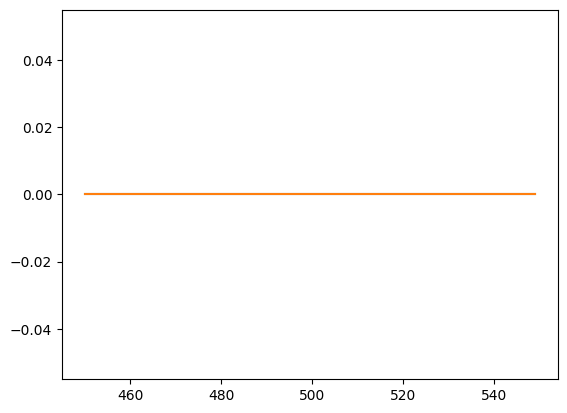

In [8]:
import matplotlib.pyplot as plt

plt.plot(origin_data['Laundry Allowed Waiting Time'][450:550])
plt.plot(origin_data['Laundry Demand'][450:550])

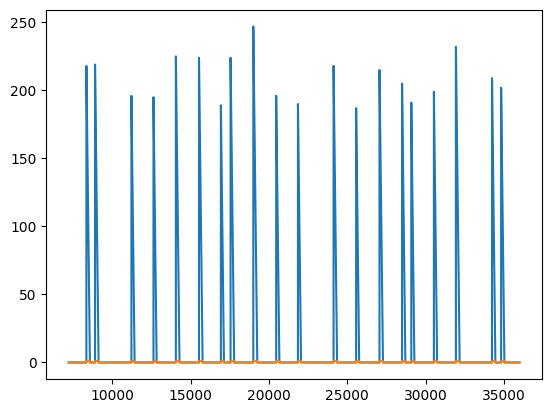

In [9]:
plt.plot(origin_data['Laundry Allowed Waiting Time'][5 * rows_per_day:25 * rows_per_day])
plt.plot(origin_data['Laundry Demand'][5 * rows_per_day:25 * rows_per_day])

In [10]:
# 保存数据
origin_data.to_csv('california_3938_2016_minute_data_modify_carbon_laundry.csv', index=False)